# Poll Forecasting Learning Diary

In STA303: Methods of Data Analysis II, I learned about GAMs (Generalized additive models) and forecasting in the `R` `Pmisc` library. In this learning diary, I'm going to do similar work in Python using a dataset not used in STA303.

In [1]:
# --- WORKPLACE SETUP ---

# run this line if pygam is not already installed
%pip install pygam

# data preparation
import pandas as pd
import numpy as np

# statistical libraries
import pygam as pg
import statsmodels.api as sm
from pygam import LinearGAM, s, f
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults

# visualizations
import matplotlib.pyplot as plt
import seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 4.2 MB/s eta 0:00:00


In [2]:
# fivethirty eight data
url = "https://raw.githubusercontent.com/fivethirtyeight/data/4c1ff5e3aef1816ae04af63218015066e186c147/polls/2024-averages/presidential_general_averages_2024-09-12_uncorrected.csv"
raw_df = pd.read_csv(url)
raw_df.head()

,candidate,date,pct_trend_adjusted,state,cycle,party,pct_estimate,hi,lo
0,Joseph R. Biden Jr.,2020-11-03,37.82732,Alabama,2020,NaN,NaN,NaN,NaN
1,Donald Trump,2020-11-03,57.36126,Alabama,2020,NaN,NaN,NaN,NaN
2,Joseph R. Biden Jr.,2020-11-02,37.82732,Alabama,2020,NaN,NaN,NaN,NaN
3,Donald Trump,2020-11-02,57.36126,Alabama,2020,NaN,NaN,NaN,NaN
4,Joseph R. Biden Jr.,2020-11-01,38.07011,Alabama,2020,NaN,NaN,NaN,NaN


In [3]:
# only get data from nov 5 2023 to july 12 2024
filtered_df = raw_df[(raw_df['date'] > '2023-11-04') & (raw_df['date'] < '2024-07-21')]
filtered_df['candidate'].value_counts()

,count
candidate,
Trump,1555
Kennedy,1555
Biden,1555


In [4]:
# national data for trump and biden
national_trump_biden = filtered_df[(filtered_df['state'] == 'National') & ((filtered_df['candidate'] == 'Trump')|(filtered_df['candidate'] == 'Biden'))]
trump_df = national_trump_biden[national_trump_biden['candidate'] == 'Trump']
biden_df = national_trump_biden[national_trump_biden['candidate'] == 'Biden']

In [5]:
trump_df = trump_df[['date', 'pct_estimate']]
biden_df = biden_df[['date', 'pct_estimate']]
trump_df = trump_df.rename(columns={'pct_estimate': 'trump_pct'})
biden_df = biden_df.rename(columns={'pct_estimate': 'biden_pct'})
national_df = pd.merge(trump_df, biden_df, on='date')
national_df['date'] = pd.to_datetime(national_df['date'])
national_df['trump_margin'] = national_df['trump_pct'] - national_df['biden_pct']
national_df

,date,trump_pct,biden_pct,trump_margin
0,2024-07-20,43.51600,40.29955,3.21645
1,2024-07-19,43.46300,40.23650,3.22650
2,2024-07-18,43.34035,40.08265,3.25770
3,2024-07-17,42.33905,40.30155,2.03750
4,2024-07-16,42.34350,40.30480,2.03870
...,...,...,...,...
137,2024-03-05,42.22820,40.06815,2.16005
138,2024-03-04,42.20815,39.98665,2.22150
139,2024-03-03,42.18145,39.74865,2.43280
140,2024-03-02,41.98310,39.55785,2.42525


In [12]:
election_date = pd.Timestamp("2024-11-05")
national_df['days_until_election'] = (election_date - national_df['date']).dt.days
national_df['trump_prop'] = national_df['trump_pct'] / 100
national_df['biden_prop'] = national_df['biden_pct'] / 100
national_df['trump_margin_prop'] = national_df['trump_margin'] / 100
national_df

,date,trump_pct,biden_pct,trump_margin,days_until_election,trump_prop,biden_prop,trump_margin_prop
0,2024-07-20,43.51600,40.29955,3.21645,108,0.435160,0.402996,0.032165
1,2024-07-19,43.46300,40.23650,3.22650,109,0.434630,0.402365,0.032265
2,2024-07-18,43.34035,40.08265,3.25770,110,0.433403,0.400827,0.032577
3,2024-07-17,42.33905,40.30155,2.03750,111,0.423391,0.403015,0.020375
4,2024-07-16,42.34350,40.30480,2.03870,112,0.423435,0.403048,0.020387
...,...,...,...,...,...,...,...,...
137,2024-03-05,42.22820,40.06815,2.16005,245,0.422282,0.400682,0.021600
138,2024-03-04,42.20815,39.98665,2.22150,246,0.422082,0.399866,0.022215
139,2024-03-03,42.18145,39.74865,2.43280,247,0.421814,0.397486,0.024328
140,2024-03-02,41.98310,39.55785,2.42525,248,0.419831,0.395578,0.024252


## Exploratory data analysis

Text(2024-06-27 00:00:00, 0, 'Debate Day')

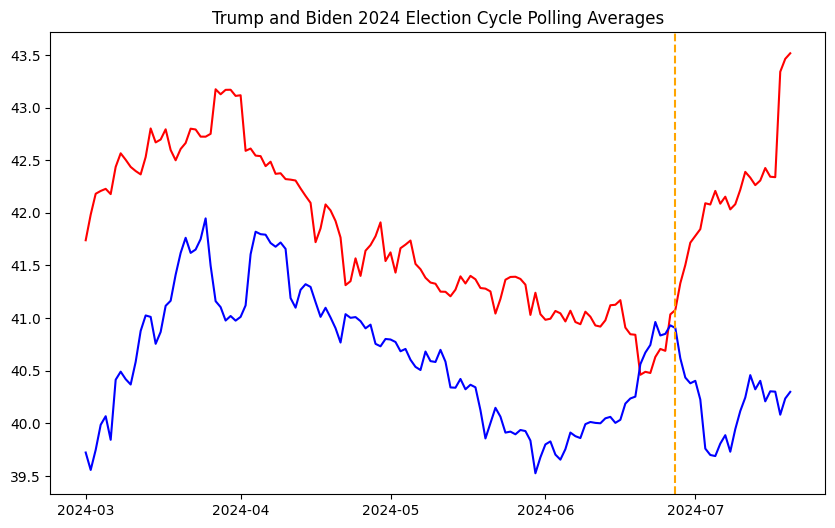

In [8]:
# plot the poll dates
plt.figure(figsize=(10, 6))
plt.title("Trump and Biden 2024 Election Cycle Polling Averages")
plt.plot(national_df['date'], national_df['trump_pct'], label='Trump', color='red')
plt.plot(national_df['date'], national_df['biden_pct'], label='Biden', color='blue')
# vertical line at june 27 2024
plt.axvline(x=pd.to_datetime('2024-06-27'), color='orange', linestyle='--') # debate
# label the horizontal line as the day of the debate


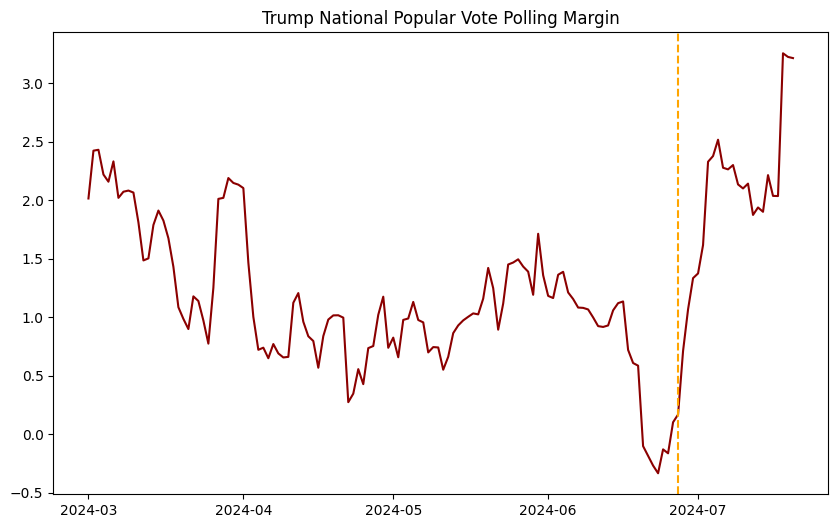

In [11]:
# plot trump's national margin
plt.figure(figsize=(10, 6))
plt.title('Trump National Popular Vote Polling Margin')
plt.plot(national_df['date'], national_df['trump_margin'], label='Trump', color='darkred')
plt.axvline(x=pd.to_datetime('2024-06-27'), color='orange', linestyle='--')

In [12]:
trump_margin_data = national_df[['date', 'trump_margin']]
trump_margin_data = trump_margin_data.sort_values(['date'])
trump_margin_data = trump_margin_data.set_index('date')
trump_margin_data

,trump_margin
date,
2024-03-01,2.01650
2024-03-02,2.42525
2024-03-03,2.43280
2024-03-04,2.22150
2024-03-05,2.16005
...,...
2024-07-16,2.03870
2024-07-17,2.03750
2024-07-18,3.25770


## Approaching Poll Forecasting as a Time Series Problem

I initially thought of this as a discrete time series analysis problem.

$x^{(1)}_{\text{biden}}, x^{(2)}_{\text{biden}}, ...,x^{(t)}_{\text{biden}} ,... x^{(T)}_{\text{biden}}$; where $x^{(t)}_{\text{biden}}$ denotes polling support % for Biden at time (day) $t$

$x^{(1)}_{\text{trump}}, x^{(2)}_{\text{trump}}, ...,x^{(t)}_{\text{trump}} ,... x^{(T)}_{\text{trump}}$; where $x^{(t)}_{\text{biden}}$ denotes polling support % for Trump at time (day) $t$

## ARIMA (Autoregressive integrated moving average)
* generalization of the autoregressive moving average (ARMA) model to incorporate a non-stationary series and periodic variation

ARIMA(p, d, q)

Where:
* AR(p) are the autoregressive terms (p is the # of past values that the current value depends on). in this case, if p=1, then the current polling value depends on only the previous day's polling value.
* I(d) aka integrated is the number of differnces that the time series needs in order to become stationary
* MA(q): moving average terms, aka the # forecast errors $q$ that the current value depends on

resources used:
* I straight up asked ChatGPT to give me a lesson on ARIMA(p, d, q)
* https://people.duke.edu/~rnau/411arim.html
* https://mcs.utm.utoronto.ca/~nosedal/sta457/arima-forecasts-theory.pdf

In [13]:
# fit the ARIMA model
arima_model = ARIMA(trump_margin_data, order=(1, 1, 1))
# in this example, the daily polling numbers depend on 1 previous day's polling nmbers, 1 difference in order to become stationary
# and 1 forecast error
arima_model_fit = arima_model.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [14]:
forecast1 = arima_model_fit.forecast(steps=107)
forecast1

,predicted_mean
2024-07-21,3.229610
2024-07-22,3.227430
2024-07-23,3.227791
2024-07-24,3.227731
2024-07-25,3.227741
...,...
2024-10-31,3.227740
2024-11-01,3.227740
2024-11-02,3.227740
2024-11-03,3.227740


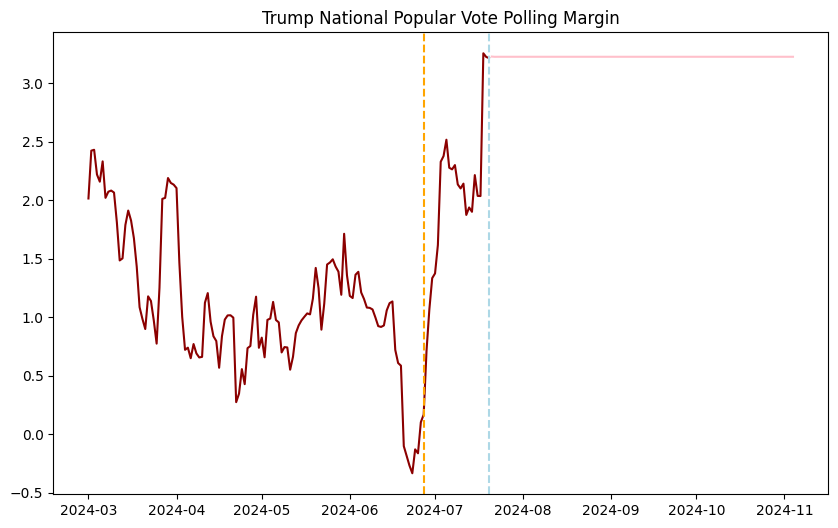

In [23]:
# plot the forecast
plt.figure(figsize=(10, 6))
plt.title('Trump National Popular Vote Polling Margin')
plt.plot(trump_margin_data.index, trump_margin_data['trump_margin'], label='Actual', color='darkred')
plt.plot(forecast1.index, forecast1, label='ARIMA Forecast', color='pink')
# vertical line june 27
plt.axvline(x=pd.to_datetime('2024-06-27'), color='orange', linestyle='--')
# verticle line july 20
plt.axvline(x=pd.to_datetime('2024-07-20'), color='lightblue', linestyle='--')

In [ ]:
# biden and trump arima
biden_data = national_df[['date', 'biden_pct']]
biden_data = biden_data.sort_values(['date'])
biden_data = biden_data.set_index('date')
trump_data = national_df[['date', 'trump_pct']]
trump_data = trump_data.sort_values(['date'])
trump_data = trump_data.set_index('date')
biden_model = ARIMA(biden_data, order=(1, 1, 1))
biden_model_fit = biden_model.fit()
trump_model = ARIMA(trump_data, order=(1, 1, 1))
trump_model_fit = trump_model.fit()
biden_forecast = biden_model_fit.forecast(steps=107)
trump_forecast = trump_model_fit.forecast(steps=107)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

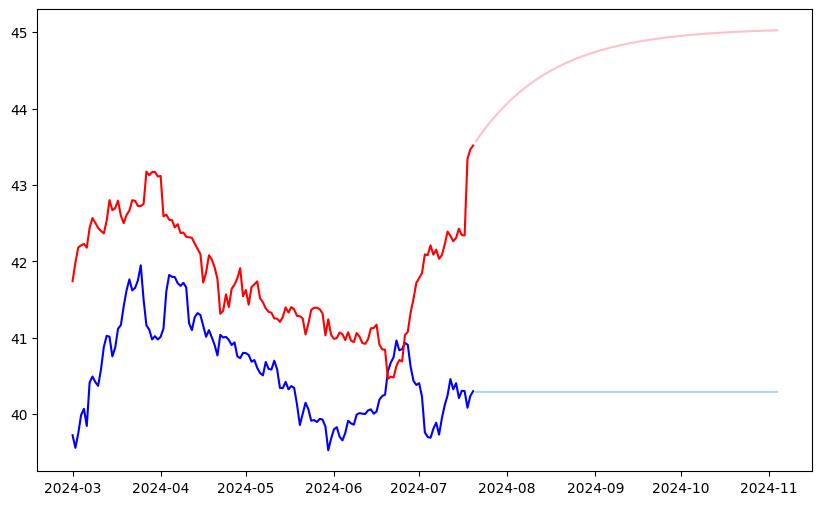

In [ ]:
# plot the forecasts and existing data
plt.figure(figsize=(10, 6))
plt.plot(biden_data.index, biden_data['biden_pct'], label='Actual', color='blue')
plt.plot(biden_forecast.index, biden_forecast, label='ARIMA Forecast', color='lightblue')
plt.plot(trump_data.index, trump_data['trump_pct'], label='Actual', color='red')
plt.plot(trump_forecast.index, trump_forecast, label='ARIMA Forecast', color='pink')

## GAM Model (analogous to R `mgcv` package)
This approach is analogous to what I learned in STA303. I am fitting a linear generalized additive model (GAM) with a smoothing function (spline) to model polling trends over time (days). Refer to STA303 notes and assignment 2 github but do this one in python instead of R. https://github.com/taliafabs/sta303a2/blob/main/sta303a2.pdf

Model:
$$
\text{Y}_i \sim N(\mu_i, \sigma^2) \\
\mu_i = \beta_0 + f(\text{date}) + \epsilon_i
$$

Where:
* $Y_i$ is the margin between Trump and Biden recorded in polls on day $i$
* $\beta_0$ is the intercept.
* $f(\text{date}_i)$ is the smooth trend over time, modelled by a spline.
* $\epsilon_i \sim N(0,\sigma^2)$  are the residuals

In [ ]:
def logit(p):
  return np.log(p/(1-p))

def sigmoid(z): # z is the logit (sigmoid is inverse logit)
  return 1/(1+exp(-z))

In [15]:
# prepare the data frame
polling_df = national_df[['days_until_election', 'trump_prop', 'biden_prop', 'trump_margin_prop']]

# logit transform the proportions
polling_df['trump_logit'] = np.log(polling_df['trump_prop'] / (1 - polling_df['trump_prop']))
polling_df['biden_logit'] = np.log(polling_df['biden_prop'] / (1 - polling_df['biden_prop']))
polling_df['trump_margin_logit'] = np.log(polling_df['trump_margin_prop'] / (1 - polling_df['trump_margin_prop']))


/tmp/ipython-input-44286774.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  polling_df['trump_logit'] = np.log(polling_df['trump_prop'] / (1 - polling_df['trump_prop']))
/tmp/ipython-input-44286774.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  polling_df['biden_logit'] = np.log(polling_df['biden_prop'] / (1 - polling_df['biden_prop']))
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **

In [18]:
# fit a GAM
X = polling_df[['days_until_election']].values
y_trump = polling_df['trump_prop']
y_biden = polling_df['biden_prop']
y_trump_margin = polling_df['trump_margin_prop']

gam_trump = LinearGAM(s(0, n_splines=20)).fit(X, y_trump)
gam_biden = LinearGAM(s(0, n_splines=20)).fit(X, y_biden)
gam_trump_margin = LinearGAM(s(0, n_splines=20)).fit(X, y_trump_margin)

In [19]:
# predict and sigmoid (chatGPT was used to debug)
xx = np.linspace(polling_df['days_until_election'].min(), polling_df['days_until_election'].max(), 1000)
xx = xx[:, None]
y_pred_trump = gam_trump.predict(xx)
y_pred_biden = gam_biden.predict(xx)
y_pred_trump_margin = gam_trump_margin.predict(xx)

## Rough work

In [ ]:
# data
url = "https://raw.githubusercontent.com/taliafabs/USPresidentialPollingForecast2024/main/data/01-raw_data/raw_data.parquet"
raw_df = pd.read_parquet(url, engine="pyarrow")

In [ ]:
reduced_df = raw_df[['poll_id', 'end_date', 'pollster', 'numeric_grade', 'pollscore', 'methodology', 'population', 'party', 'candidate_name', 'pct']]
reduced_df['end_date'] = pd.to_datetime(reduced_df['end_date'])
reduced_df = reduced_df.sort_values(by=['end_date', 'poll_id', 'methodology', 'population'])
filtered_df = reduced_df[(reduced_df['end_date'] > '2023-11-04') &
                         (reduced_df['end_date'] < '2024-07-21') &
                         (reduced_df['party'].isin(["DEM", "REP"])) &
                         (reduced_df['numeric_grade'] >= 3) &
                         (~pd.isna(reduced_df['numeric_grade']))
                         ]
clean_polls_df = filtered_df[['poll_id', 'end_date', 'candidate_name', 'pct']]
biden = clean_polls_df['candidate_name'] == 'Joe Biden'
trump = clean_polls_df['candidate_name'] == 'Donald Trump'
clean_polls_df = clean_polls_df[biden | trump]

/tmp/ipython-input-1829961825.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  reduced_df['end_date'] = pd.to_datetime(reduced_df['end_date'])
/tmp/ipython-input-1829961825.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df['end_date'] = pd.to_datetime(reduced_df['end_date'])


In [ ]:
filtered_df

,poll_id,end_date,pollster,numeric_grade,pollscore,methodology,population,party,candidate_name,pct
12336,84685.0,2023-11-07,Marquette Law School,3.0,-1.1,Probability Panel,lv,DEM,Joe Biden,49.0
12337,84685.0,2023-11-07,Marquette Law School,3.0,-1.1,Probability Panel,lv,REP,Donald Trump,51.0
12340,84685.0,2023-11-07,Marquette Law School,3.0,-1.1,Probability Panel,lv,DEM,Joe Biden,49.0
12341,84685.0,2023-11-07,Marquette Law School,3.0,-1.1,Probability Panel,lv,REP,Ron DeSantis,51.0
12344,84685.0,2023-11-07,Marquette Law School,3.0,-1.1,Probability Panel,lv,DEM,Joe Biden,44.0
...,...,...,...,...,...,...,...,...,...,...
6173,87437.0,2024-07-16,YouGov,3.0,-1.1,Online Panel,rv,REP,Donald Trump,44.0
5969,87483.0,2024-07-18,YouGov,3.0,-1.1,Online Panel,lv,DEM,Joe Biden,47.0
5970,87483.0,2024-07-18,YouGov,3.0,-1.1,Online Panel,lv,REP,Donald Trump,52.0
5971,87483.0,2024-07-18,YouGov,3.0,-1.1,Online Panel,lv,DEM,Kamala Harris,48.0


In [ ]:
filtered_df['pollster'].value_counts()

,count
pollster,
YouGov,210
Siena/NYT,120
Marquette Law School,68
YouGov Blue,6


In [ ]:
biden_df = filtered_df[filtered_df['candidate_name'] == 'Joe Biden']
trump_df = filtered_df[filtered_df['candidate_name'] == 'Donald Trump']
biden_df

,poll_id,end_date,pollster,numeric_grade,pollscore,methodology,population,party,candidate_name,pct
12336,84685.0,2023-11-07,Marquette Law School,3.0,-1.1,Probability Panel,lv,DEM,Joe Biden,49.0
12340,84685.0,2023-11-07,Marquette Law School,3.0,-1.1,Probability Panel,lv,DEM,Joe Biden,49.0
12344,84685.0,2023-11-07,Marquette Law School,3.0,-1.1,Probability Panel,lv,DEM,Joe Biden,44.0
12334,84685.0,2023-11-07,Marquette Law School,3.0,-1.1,Probability Panel,rv,DEM,Joe Biden,48.0
12338,84685.0,2023-11-07,Marquette Law School,3.0,-1.1,Probability Panel,rv,DEM,Joe Biden,49.0
...,...,...,...,...,...,...,...,...,...,...
6435,87404.0,2024-07-12,Siena/NYT,3.0,-1.5,Live Phone,lv,DEM,Joe Biden,40.0
6425,87404.0,2024-07-12,Siena/NYT,3.0,-1.5,Live Phone,rv,DEM,Joe Biden,46.0
6429,87404.0,2024-07-12,Siena/NYT,3.0,-1.5,Live Phone,rv,DEM,Joe Biden,38.0
6167,87437.0,2024-07-16,YouGov,3.0,-1.1,Online Panel,rv,DEM,Joe Biden,41.0


In [ ]:
trump_df

,poll_id,end_date,pollster,numeric_grade,pollscore,methodology,population,party,candidate_name,pct
12337,84685.0,2023-11-07,Marquette Law School,3.0,-1.1,Probability Panel,lv,REP,Donald Trump,51.0
12335,84685.0,2023-11-07,Marquette Law School,3.0,-1.1,Probability Panel,rv,REP,Donald Trump,52.0
12282,84686.0,2023-11-13,YouGov,3.0,-1.1,Online Panel,rv,REP,Donald Trump,44.0
12220,84681.0,2023-11-14,YouGov,3.0,-1.1,Online Panel,rv,REP,Donald Trump,43.0
11999,84828.0,2023-11-27,YouGov,3.0,-1.1,Online Panel,a,REP,Donald Trump,37.0
...,...,...,...,...,...,...,...,...,...,...
6446,87404.0,2024-07-12,Siena/NYT,3.0,-1.5,Live Phone,rv,REP,Donald Trump,38.0
6168,87437.0,2024-07-16,YouGov,3.0,-1.1,Online Panel,rv,REP,Donald Trump,43.0
6173,87437.0,2024-07-16,YouGov,3.0,-1.1,Online Panel,rv,REP,Donald Trump,44.0
5970,87483.0,2024-07-18,YouGov,3.0,-1.1,Online Panel,lv,REP,Donald Trump,52.0


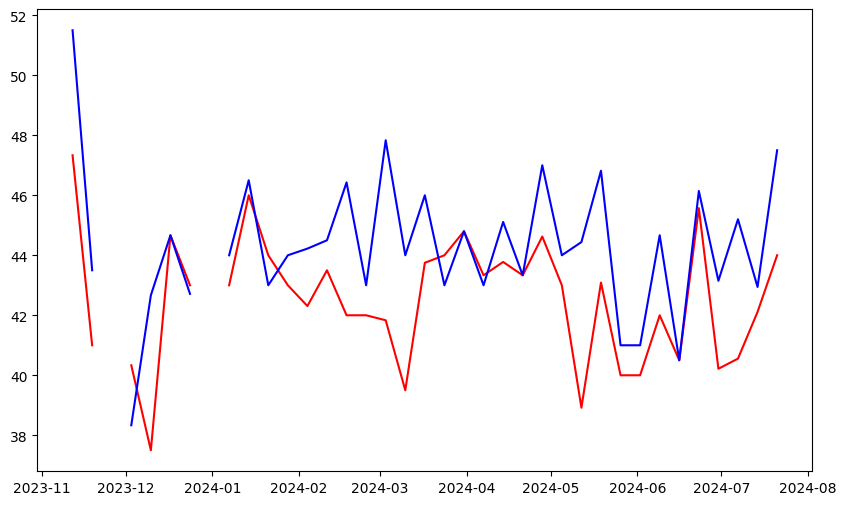

In [ ]:
# plot weekly polling averages
biden_weekly_avg = biden_df.groupby(pd.Grouper(key='end_date', freq='W'))['pct'].mean()
trump_weekly_avg = trump_df.groupby(pd.Grouper(key='end_date', freq='W'))['pct'].mean()

plt.figure(figsize=(10, 6))
# vertical line for debate
# plt.axvline(x='2024-06-27', color='black', linestyle='--')
plt.plot(biden_weekly_avg.index, biden_weekly_avg.values, label='Biden', color='red')
plt.plot(trump_weekly_avg.index, trump_weekly_avg.values, label='Trump', color='blue')

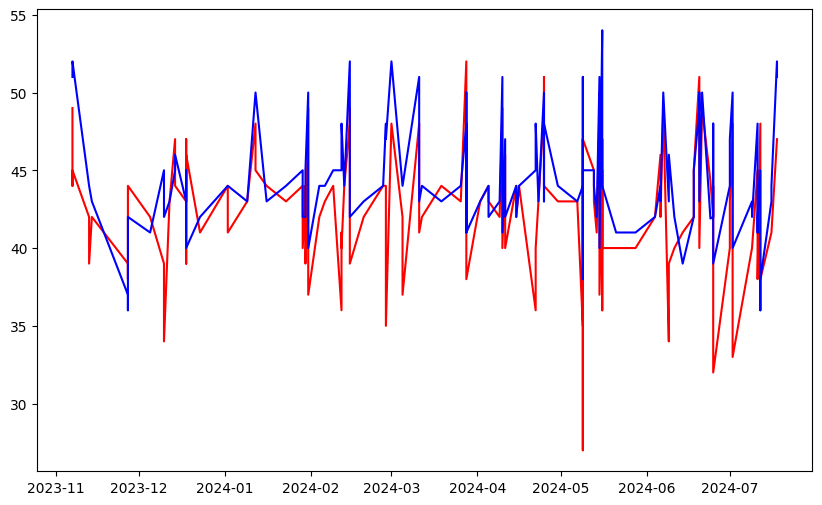

In [ ]:
# plot all polls
plt.figure(figsize=(10, 6))
plt.plot(biden_df['end_date'], biden_df['pct'], label='Biden', color='red')
plt.plot(trump_df['end_date'], trump_df['pct'], label='Trump', color='blue')

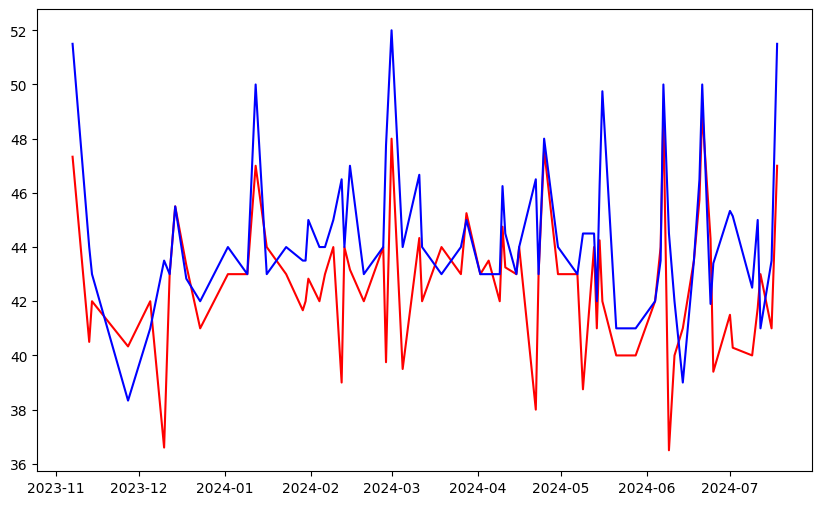

In [ ]:
# polling averages up to each date
biden_cumulative_avg = biden_df.groupby('end_date')['pct'].mean()
trump_cumulative_avg = trump_df.groupby('end_date')['pct'].mean()

# plot it
plt.figure(figsize=(10, 6))
plt.plot(biden_cumulative_avg.index, biden_cumulative_avg.values, label='Biden', color='red')
plt.plot(trump_cumulative_avg.index, trump_cumulative_avg.values, label='Trump', color='blue')

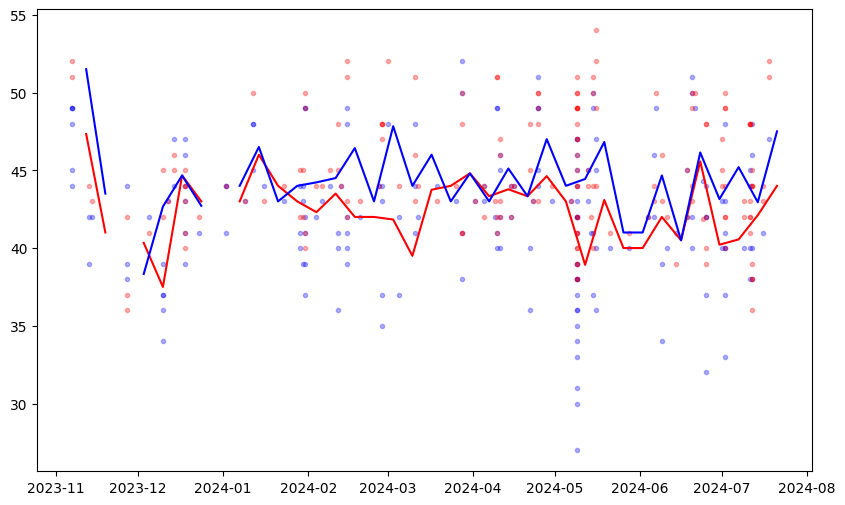

In [ ]:
# plot the individual polls
plt.figure(figsize=(10, 6))
plt.plot(biden_df['end_date'], biden_df['pct'], label='Biden', color='blue', marker='o', linestyle='', alpha=0.3, markersize=3)
plt.plot(trump_df['end_date'], trump_df['pct'], label='Trump', color='red', marker='o', linestyle='', alpha=0.3, markersize=3)

# plot weekly average
plt.plot(biden_weekly_avg.index, biden_weekly_avg.values, label='Biden', color='red')
plt.plot(trump_weekly_avg.index, trump_weekly_avg.values, label='Trump', color='blue')

# plt.plot(trump_df['end_date'], trump_df['pct'], label='Trump', color='blue')